In [316]:
import sys
import os
import time
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
import json


In [317]:
# 获取域名元数据
metad = {}
with open("/root/Workspace/DWTF/domain_relation/src/secrank1k-metadata.txt","r") as inf:
    for line in tqdm(inf.readlines(), desc="Get domains' meta data"):
        td = eval(line.strip())
        metad[td['sld']] = td

Get domains' meta data:   0%|          | 0/1000 [00:00<?, ?it/s]

In [318]:
## 更新入度信息
def upgrade_in_degree(G):
    for n in G.nodes():
        nx.set_node_attributes(G, {n:{'indegree':G.in_degree(n)}})

In [319]:
## 有向图转json
def graph2json(G):
    #改用默认的方法
    upgrade_in_degree(G)
    res = json_graph.node_link_data(G)
    del res["directed"]
    del res["multigraph"]
    del res["graph"]
    return res

    
    # d = {'nodes':[], 'links':[]}
    # # 节点信息
    # for n in G.nodes():
    #     tj = G.nodes.data()[n]
    #     tj['id'] = n
    #     tj['indegree'] = G.in_degree(n)
    #     d['nodes'].append(tj)
    # # 边信息
    # d['links'] = [{'source': u, 'target': v, 'color':G.edges[u,v]['color']} for u, v in G.edges()]
    # return d

In [320]:
## 去除自环
def wipecycle(G):
    remove_edges = []
    for u,v in G.edges():
        if u == v:
            remove_edges.append((u,v))
    for i in remove_edges:
        G.remove_edge(i[0], i[1])

In [321]:
# 给图增加其他元数据
def addmetadata(G):
    for n in tqdm(G.nodes(), desc="Add mate data to josn"):
            try:
                nx.set_node_attributes(G, {n:{'requestCount': metad[n]['requestCount']}})
                nx.set_node_attributes(G, {n:{'clientIpCount': metad[n]['clientIpCount']}})
                nx.set_node_attributes(G, {n:{'subdomainCount': metad[n]['subdomainCount']}})
            except Exception as e:
                pass

In [322]:
# 增加点和线的颜色属性

## 增加默认的绿色属性
def addg(G):
    # 添加节点属性
    for i in G.nodes():
        nx.set_node_attributes(G, {i:{'color':'green'}})
    # 添加边的属性
    for e in G.edges():
        nx.set_edge_attributes(G, {e:{'color':'green'}})

def addr(G, breakN, breakE):
    # 更改节点属性
    for i in breakN:
        nx.set_node_attributes(G, {i:{'color':'red'}})
    # 更改边的属性
    for e in breakE:
        nx.set_edge_attributes(G, {e:{'color':'red'}})

In [323]:
## block一个域名，返回受影响的线和边，直接修改颜色信息
# TODO: 没有考虑到互环的情况，应该增加一种判断，一个点到不了根节点就算失效，但边可以先保留

def blockdomain(G, domainname):
    blockAdomain(G, domainname=domainname)

def blockAdomain(G, domainname):
    print("[++++++]"+domainname+" blocked !")
    nx.set_node_attributes(G, {domainname: {'color': 'red'}})
    
    # 更新所有指向该点的边
    for edge in G.in_edges(domainname):
        nx.set_edge_attributes(G, {edge: {'color': 'red'}})
        print("[------]edge {} donw".format(edge))
        
    # 获取所有指向该点的点, 判断是否需要继续block，深度优先
    for src in G.predecessors(domainname):
        print("[------]check node %s" % src)
        # 判断是否所有的outedge都已不可用
        blocked = True
        for edge in G.out_edges(src):
            if G.edges[edge]['color'] == 'green':
                blocked = False
                print("[------]outedge {} alive, this node ok" .format(edge))
                break
        #所有出边均已不可用，下线该点
        if blocked:
            blockAdomain(G, domainname=src)

In [324]:
## 提取指定有向图，输出默认颜色（green）的json文件
import networkx as nx
from networkx.readwrite import json_graph
from pprint import pprint

tars = ['edu', 'gov', 'other']
nxs = {}
for i in tars:
    nxs[i] = pickle.load(open("/root/Workspace/DWTF/domain_relation/data/%s.graph_set_global.bin" % i, "rb"))

wc = True

for u,v in nxs.items():
    if wc:
        wipecycle(v['general'])
    # 添加其他元数据
    addmetadata(v['general'])
    #增加默认的颜色属性
    addg(v['general'])
    # 转json
    j = graph2json(v['general'])

    json_data = json.dumps(j, indent=4)
    with open("../data/%s.graph_set_global.json"%u, "w+") as ouf:
        ouf.write(json_data)



Add mate data to josn:   0%|          | 0/175 [00:00<?, ?it/s]

Add mate data to josn:   0%|          | 0/215 [00:00<?, ?it/s]

Add mate data to josn:   0%|          | 0/332 [00:00<?, ?it/s]

In [325]:
# block掉某个域名后的情况

blockdomain(nxs['edu']['general'], '.')

j = graph2json(nxs['edu']['general'])
json_data = json.dumps(j, indent=4)
with open("../data/%s.graph_set_global.block%s.json"%("edu", "edu.cn"), "w+") as ouf:
    ouf.write(json_data)

[++++++]. blocked !
[------]edge ('com', '.') donw
[------]edge ('net', '.') donw
[------]edge ('cn', '.') donw
[------]edge ('edu', '.') donw
[------]check node com


TypeError: not all arguments converted during string formatting

In [ ]:
def delRed(G):
    delN = []
    for n in G.nodes():
        if G.nodes[n]['color'] == 'red':
            delN.append(n)
    for i in delN:
        G.remove_node(i)
    delE = []
    for e in G.edges():
        if G.edges[e]['color'] == 'red':
            delE.append(e)
    for j in delE:
        G.remove_edge(j)


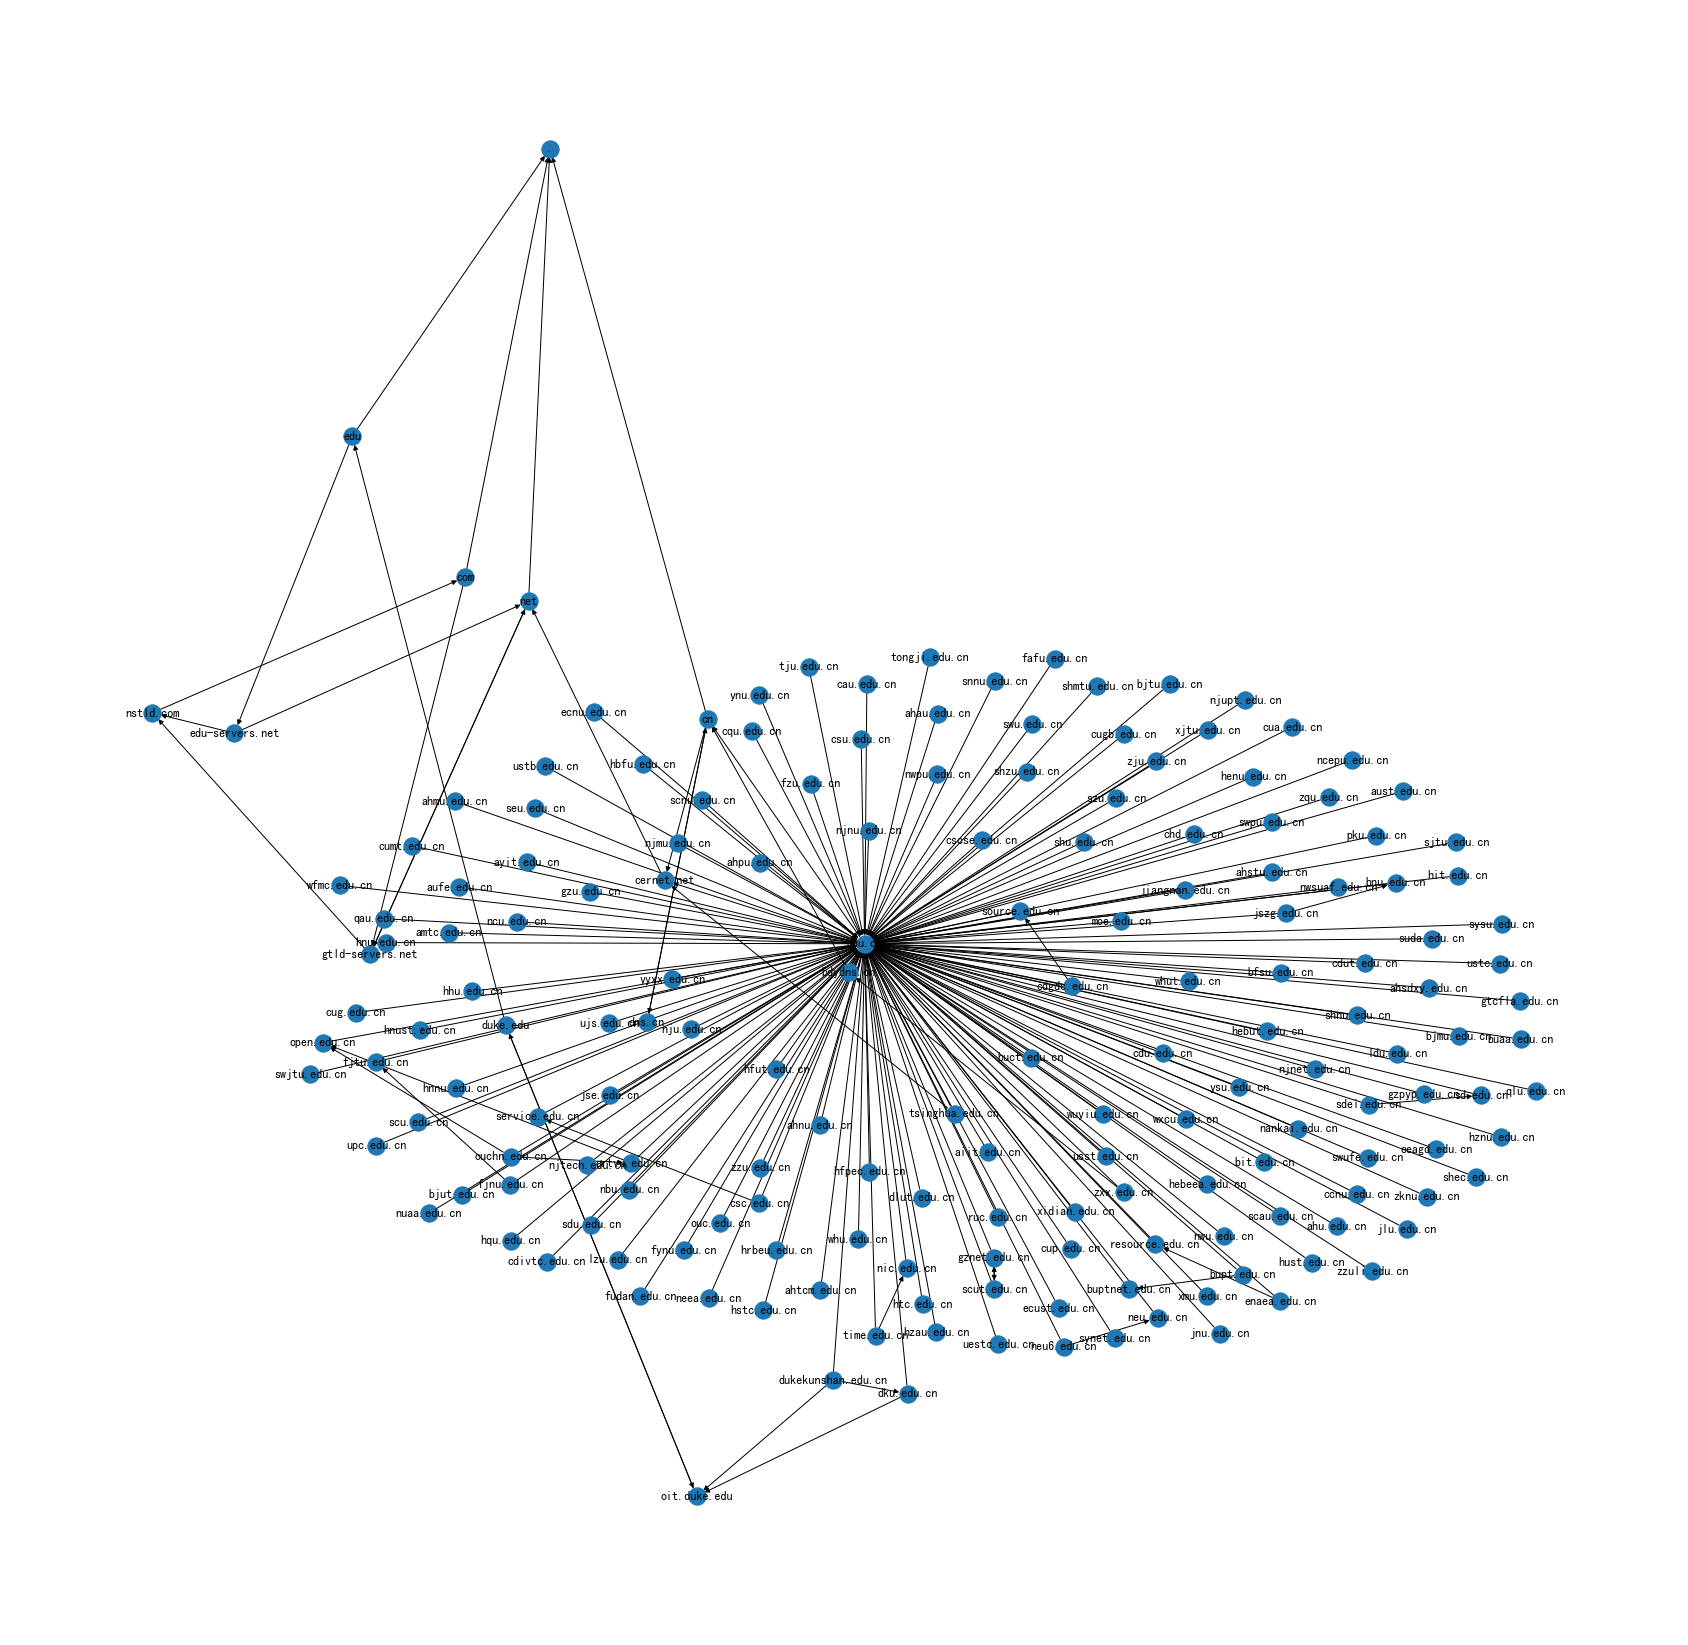

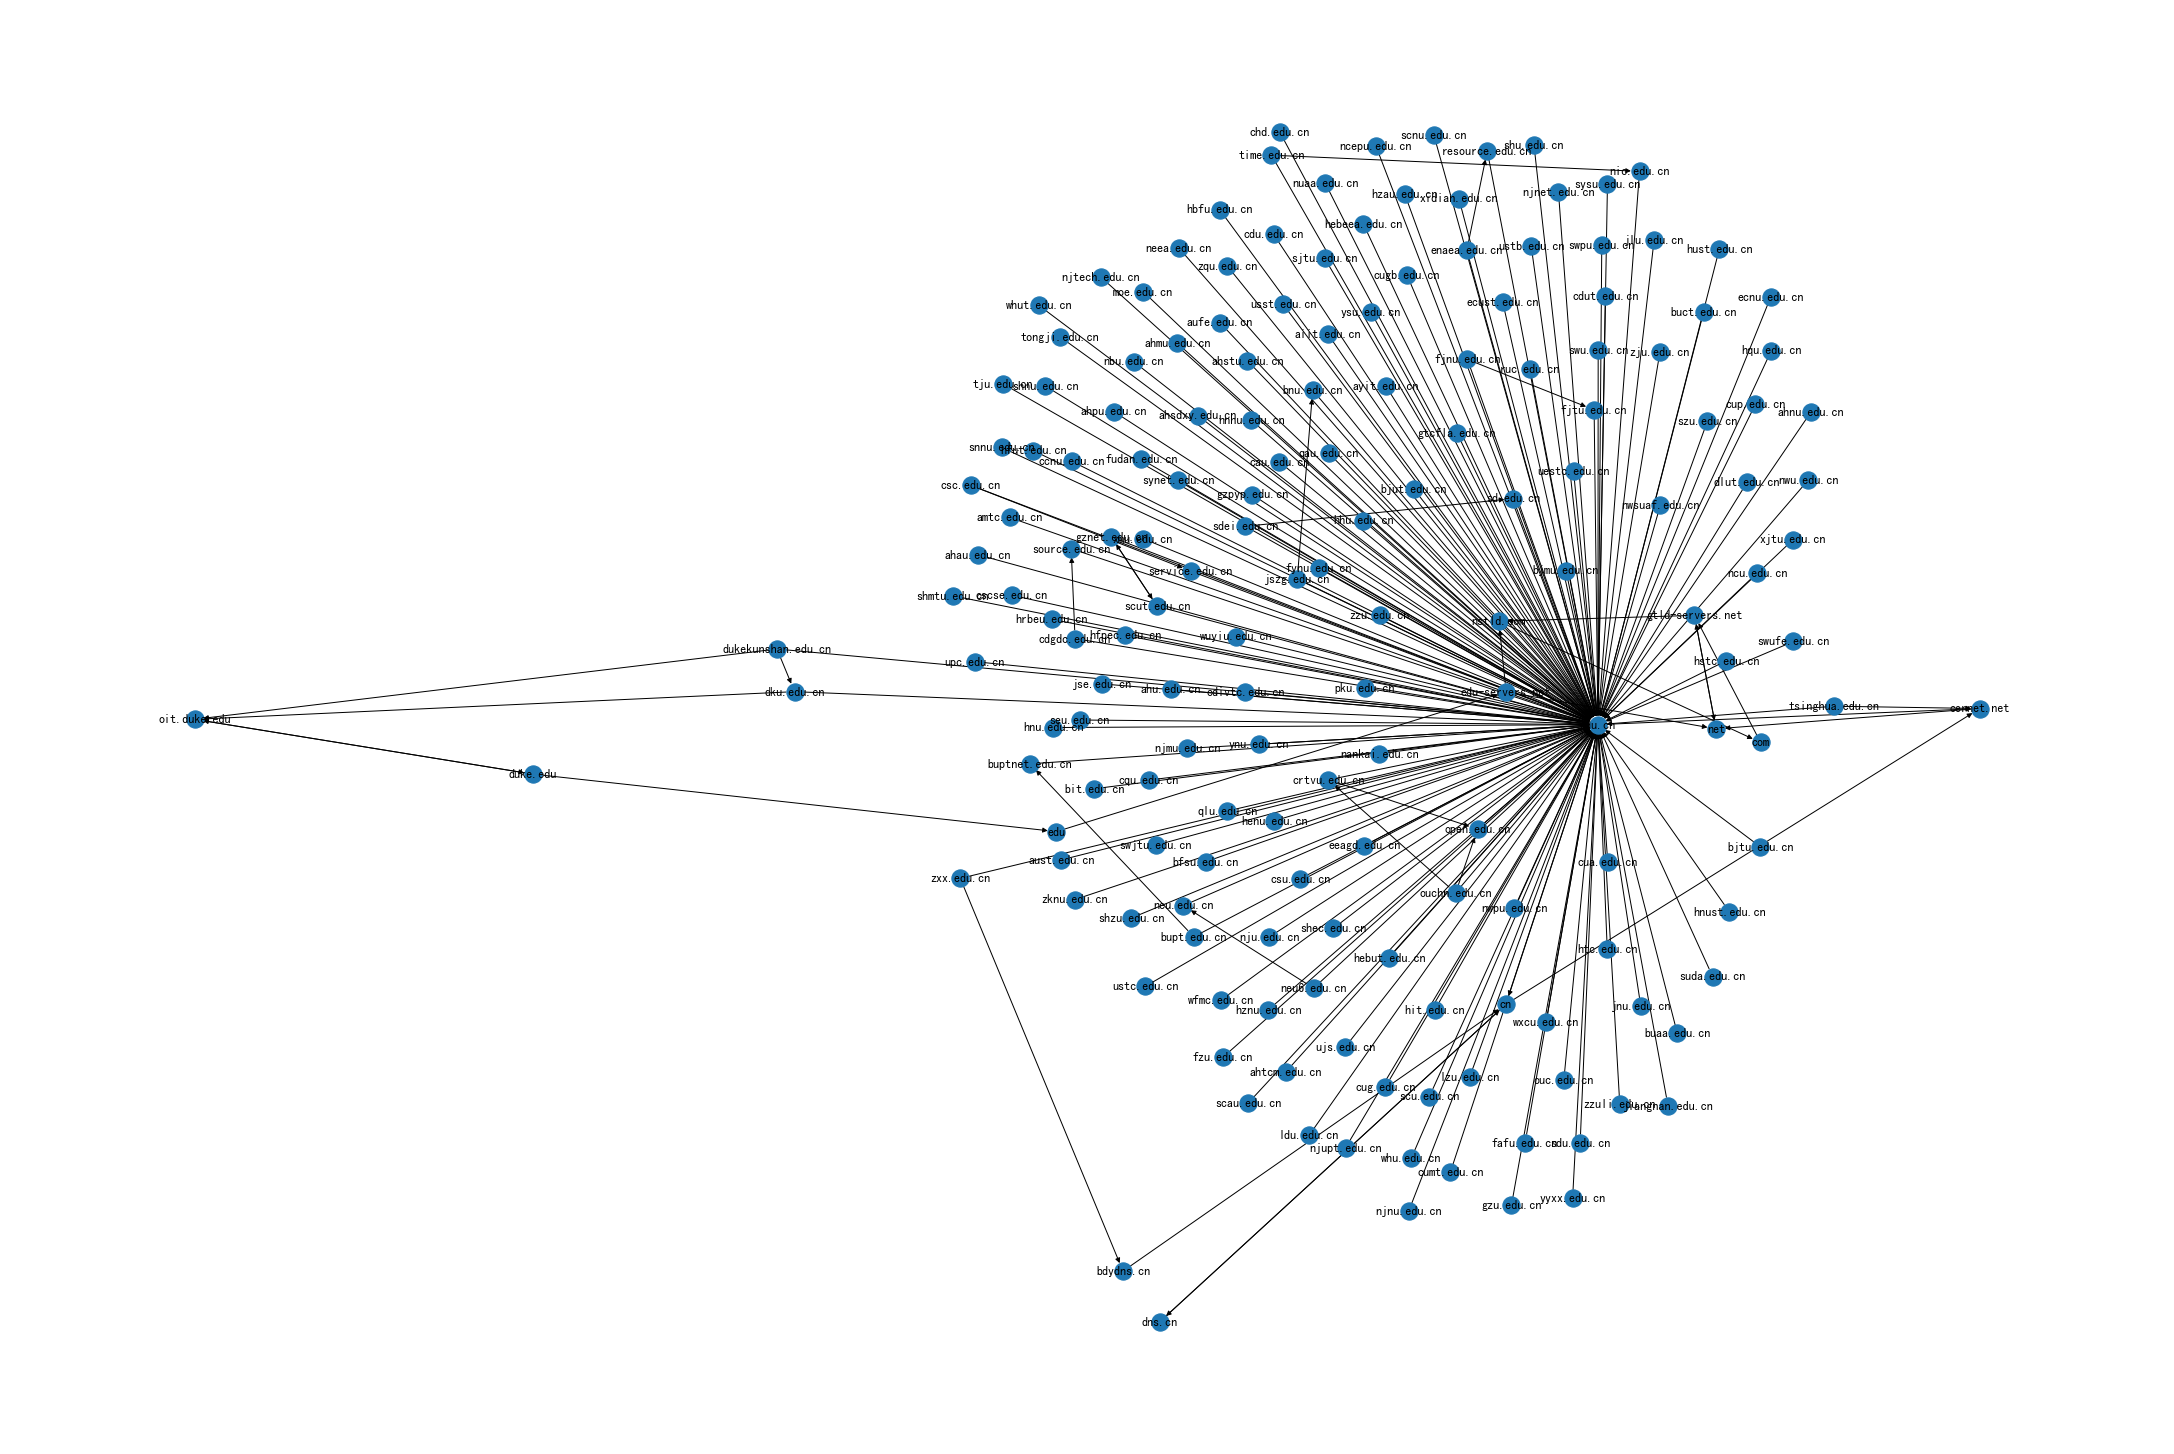

In [ ]:
# 绘图
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
nx.draw_spring(nxs['edu']['general'], with_labels=True, ax=ax)
plt.show()

delRed(nxs['edu']['general'])

plt.figure(figsize=(30, 20))
nx.draw_spring(nxs['edu']['general'], with_labels=True)
plt.show()
